In [40]:
# Note: this code is copied from DUDL_metaparams_multioutput.ipynb (section "Metaparameters")

In [41]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_32432/3865040932.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# A brief aside on saving the highest of random numbers

In [42]:
the_best = [0, 0]

for i in range(10):
    # "Train" the model
    accuracy = np.random.rand()
    
    print(f'Run: {i + 1} | Accuracy: {accuracy}')

    # See if this is better than any previous runs
    if (accuracy > the_best[0]):
        the_best = [accuracy, i]

print(f'\nHighest "accuracy" was {100 * the_best[0]:.2f}% in run {the_best[1] + 1}')

Run: 1 | Accuracy: 0.41506321493683396
Run: 2 | Accuracy: 0.48220924975161406
Run: 3 | Accuracy: 0.9490551599760494
Run: 4 | Accuracy: 0.08857899016336146
Run: 5 | Accuracy: 0.11273002634243279
Run: 6 | Accuracy: 0.8407527551247408
Run: 7 | Accuracy: 0.4323237194714692
Run: 8 | Accuracy: 0.8560149315918053
Run: 9 | Accuracy: 0.24901649819239335
Run: 10 | Accuracy: 0.8078489084118977

Highest "accuracy" was 94.91% in run 3


# Create and inspect the data

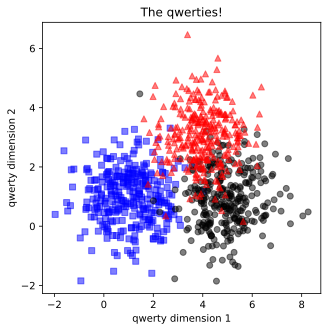

In [43]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 3]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [44]:
# Specify sizes of the partitions
# Order is train, devset, test
partitions = [3 * n_per_clust - 400, 200, 200]

# Split the data
train_data, dev_test_data, train_labels, dev_test_labels = train_test_split(data, labels, train_size=partitions[0])

# Now split the devtest data
dev_data, test_data, dev_labels, test_labels             = train_test_split(dev_test_data, dev_test_labels, train_size=partitions[1])

# Print out the sizes
print(f'   Total data size: {data.shape}')
print('--------------------------------------------')
print(f'Training data size: {train_data.shape}')
print(f'  Devset data size: {dev_data.shape}')
print(f'    Test data size: {test_data.shape}')

# Convert them into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
dev_data   = TensorDataset(dev_data,   dev_labels)
test_data  = TensorDataset(test_data,  test_labels)

# Translate into DataLoader objects
batch_size   = 30
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader   = DataLoader(dataset=dev_data,   batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(dataset=test_data,  batch_size=test_data.tensors[0].shape[0])

   Total data size: torch.Size([900, 2])
--------------------------------------------
Training data size: torch.Size([500, 2])
  Devset data size: torch.Size([200, 2])
    Test data size: torch.Size([200, 2])


# Create and validate the model

In [45]:
def create_the_qwety_net():
    """"
    META_PARAMS_MULTIOUTPUTS | DATA_SAVE_BEST_MODEL
    """
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear (2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01)

    return net, loss_func, optimizer

# A function that trains the model

In [46]:
def train_the_model():
  """
  DATA_SAVE_BEST_MODEL
  """

  # Initialize a Dictionary for the best model
  the_best_model = {'Accuracy': 0, 'net': None}

  num_epochs = 100
  
  net, loss_func, optimizer = create_the_qwety_net()

  # Initialize accuracies as empties
  train_acc = []
  dev_acc   = []
  losses    = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc  = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(dev_loader))   # Extract x,y from test dataloader
    net.eval()                      # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      pred_labels = net(X)

    # Compute accuracy
    dev_acc.append(100 * torch.mean(((torch.argmax(pred_labels, axis=1)) == y).float()))

    # Store this model if it's the best so far
    if (dev_acc[-1] > the_best_model['Accuracy']):
      # New best accuracy
      the_best_model['Accuracy'] = dev_acc[-1].item()

      # Model's internal state
      the_best_model['net']      = copy.deepcopy(net.state_dict())

  # Function output
  return train_acc, dev_acc, losses, the_best_model

# Run the model and plot the results

In [53]:
# Run the model
train_acc, dev_acc, losses, the_best_model = train_the_model()

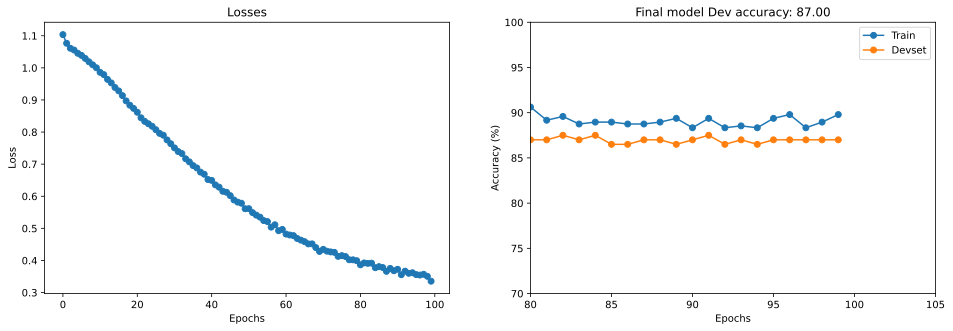

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.detach(), 'o-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')

ax[1].plot(train_acc, 'o-', label='Train')
ax[1].plot(dev_acc,   'o-', label='Devset')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model Dev accuracy: {dev_acc[-1]:.2f}')
ax[1].set_ylim([70, 100])
ax[1].set_xlim([80, 105])
ax[1].legend()

plt.show()

In [49]:
the_best_model

{'Accuracy': 89.0,
 'net': OrderedDict([('input.weight',
               tensor([[ 0.4980, -0.0442],
                       [ 0.5055,  0.6231],
                       [ 0.5809, -0.0250],
                       [-0.1038, -0.6592],
                       [ 0.5312, -0.1968],
                       [-0.3983, -0.4861],
                       [ 0.4415, -0.4814],
                       [ 0.7198, -0.8122]])),
              ('input.bias',
               tensor([-0.5776, -0.9682, -0.4997,  0.5815,  0.6474, -0.1845, -0.5122,  0.1176])),
              ('fc1.weight',
               tensor([[ 0.3971, -0.0213,  0.5179, -0.2010,  0.3690,  0.0833,  0.4395,  0.4625],
                       [ 0.2056, -0.0536,  0.1192, -0.0985, -0.0842, -0.3313,  0.0655,  0.4229],
                       [ 0.1556,  0.8186,  0.4696, -0.3050, -0.2229,  0.0620, -0.3692, -0.0505],
                       [-0.0493,  0.4393,  0.2007, -0.2591,  0.1566,  0.0495, -0.2462, -0.3493],
                       [-0.2483,  0.3861, -0.1386, -

In [55]:
# Recreate the best-performing model
best_net = create_the_qwety_net()[0]
best_net.load_state_dict(the_best_model['net'])

# Run the data through TEST
X, y     = next(iter(test_loader))
y_hat    = best_net(X)
best_acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float())

best_acc
  

tensor(90.5000)

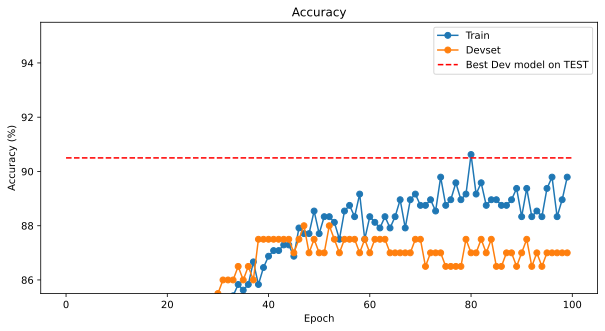

In [57]:
fig = plt.figure(figsize=(10, 5))

plt.plot(train_acc, 'o-', label='Train')
plt.plot(dev_acc,   'o-', label='Devset')
plt.plot([0, len(dev_acc)], [best_acc, best_acc], 'r--', label='Best Dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.ylim([best_acc - 5, best_acc + 5])
plt.legend()
plt.show()